<a href="https://colab.research.google.com/github/ivanorsolic/NMAProject-HMM/blob/master/Project%3A%20Detecting%20latent%20state%20sequences%20using%20HMMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The scientific question: 

- Can neural activity in the mouse cortex be described by discrete state sequences and do these sequences correlate with behaviour?  
- How are state transitions correlated across brain areas? 
- Can we find differences in neural activity for correct and incorrect decisions?

# Brief scientific background: 

Evidence accumulates that cortical activity in areas like the primary gustatory cortex unfolds as discrete state sequences. These state sequences are thought to be representations of internal variables and behaviour.

Complex behaviour, such as performing a decision-making task, is encoded by neuronal firing of various brain areas that are structurally and functionally highly interconnected, such as visual cortex, cingulate cortex, amygdala and prefrontal cortex. 

As of yet, it is still unclear in which brain areas neural activity indeed unfolds as state sequences and how these sequences correlate across different brain areas and with behaviour.

# Proposed analyses

We will analyse single-trial population activity using hidden Markov models (HMM) to investigate whether neural activity unfolds as state sequences. We would then compare discovered state sequences for different stimuli and compare results across brain regions and for different behaviours (correct and incorrect decisions).

# Predictions:

We expect to find state sequences in the cortex that can be correlated to behaviour. We predict that states in primary and higher cortices of the same sensory modality are related and that states in the primary cortices should precede those in higher cortices. We also expect states between cortices of different sensory modalities to correlate. In the visual cortex, we expect not to find differences between correct and incorrect go trials.

# Possible alternative outcomes:

- The state sequences can’t be related to behaviour
- No temporal delay between state transitions along the visual hierarchy
- In the visual cortex we find a difference between incorrect and correct go trials

# Controls used:
- Correlating activity with behaviour

# What would the results mean if predictions were true

- We would show that neural activity in these cortical areas can be described by state sequences which reflect behaviour
- If we found a temporal delay, this would again show that there is a cortical (visual) hierarchy in processing information
- We could predict behaviour from neural activity (decoding)

# Results:

Using the Steinmetz dataset, we asked whether neural activity in the mouse cortex can be described by discrete state sequences and whether these sequences correlate with behaviour.  

Earlier studies have already shown that cortical activity in areas like the rat primary gustatory cortex unfolds as discrete state sequences. We wanted to see whether we can also find such states in the mouse primary visual cortex and secondary motor cortex during a visual discrimination task and whether these states could predict behaviour.

In order to achieve this, we fitted a Hidden Markov Model to the spiking neural data.
While in the primary visual cortex the found states did not reflect behaviour, in the secondary motor cortex it was possible to map the states two a short phase of movement initiation, a locomotion phase and a phase that corresponded to no movement.

We therefore conclude that in M2, cortical activity might indeed unfold as a sequence of discrete states. In the case of V1, we believe that more data would be needed for a proper statistical analysis.

# References:

1. Abeles et al. 1995 - first study to apply HMM
2. Cunningham and Yu 2014 - Review on dimensionality reduction
3. La Camera et al. 2019 - Review on state sequences in neural activity (metastable activity) and how HMM can be used to find them (Again: HMM have the assumptions that there are these discrete states) **
4. Mazzucato et al. 2015 - Here they apply HMM to gustatory cortex data
5. Assessing the goodness-of-fit of HMM - how do we know that discovered states make sense?
6. Detecting Neural-State Transitions using HMMs for Motor Cortical Prosthesis - similar 




In [ ]:
# @title Presentation video
from IPython.display import HTML
HTML('<iframe width="1280" height="720" src="https://www.youtube.com/embed/KKw8iO047jE" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

# Loading the dataset

In [ ]:
#@markdown  ##Download the data from OSF
#@markdown ###This takes a while.
import numpy as np
import pandas as pd
import os

files = [['steinmetz_st.npz', 'https://osf.io/4bjns/download'],
         ['steinmetz_part1.npz', 'https://osf.io/agvxh/download'],
         ['steinmetz_part2.npz', 'https://osf.io/uv3mw/download'],
         ['steinmetz_part3.npz', 'https://osf.io/ehmw2/download']]

for file in files:
  if file[0] not in os.listdir():
    !wget -qO {file[0]} {file[1]}

In [ ]:
#@markdown ## Load the data into variables
#@markdown ###This takes **a while**.
import numpy as np


alldat = np.array([])
for file in files[1:]:
  alldat = np.hstack((alldat, np.load(file[0], allow_pickle=True)['dat']))


dat_ST = np.load(files[0][0], allow_pickle=True)['dat']

## Main dataset
`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. For each dat = `alldat[k]`, there are the following fields:

* `dat['spks']`: neurons by trials by time bins. Time bin = 10ms.   
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['response']`: which side the response was (-1, 0, 1). Choices for the right stimulus are -1.  
* `dat['response_times']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and always does!). 
* `dat['wheel']`: exact position of the wheel that the mice uses to make a response, binned at 10ms. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small). 
* `dat['lfp']`: recording of the local field potential in each brain area from this experiment, binned at 10ms.
* `dat['brain_area_lfp']`: brain area names for the LFP channels. 

## Supplementary spike time dataset
`dat_ST` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019, supplemental to the main data provided for NMA. Time bins for all measurements are 10ms, starting 500ms before stimulus onset (same as the main data):


* `dat['ss']`: neurons by trials. Exact spikes times for each neuron and each trial, reference to the stimulus onset. A (neuron,trial) entry can be an empty list if that neuron did not fire at all on that trial. 
* `dat['ss_passive']`: same as above for `X` = {`ss`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 

In [ ]:
#@markdown ## Create helper functions
def extractNeuronsFromSpecificBrainRegion(brainRegionName, data):
  matchedSessions = {}

  for sessionId in range(39):
    session = data[sessionId]
    if brainRegionName in session['brain_area']:
      neuronIndices = [index for index, label in enumerate(session['brain_area']) if label == brainRegionName]
      matchedSessions[sessionId] = neuronIndices
  return matchedSessions

def getListOfSessionsFromNeurons(matchedSessions):
  return matchedSessions.keys()

def extractData(wantedData):
  data = []
  for session in alldat:
    data.append(session[wantedData])
  return data

def extractDataFromSession(sessionId, wantedData):
  return alldat[sessionId][wantedData]

def extractDataForNeuronsFromSession(neuronIndices, sessionId, wantedData):
  return alldat[sessionId][wantedData][neuronIndices[sessionId]]

def getSpikeCountDataForNeurons(neuronIndices, sessionId):
  # Returns an (NxTxt) array with the following dimensions:
  # N: individual neurons
  # T: trials for each neuron
  # t: time bins for each trial
  return extractDataForNeuronsFromSession(neuronIndices, sessionId, 'spks')

def getSpikeCountForSpecificNeuronAndSession(spikeCountData, neuronIndex, sessionIndex):
  return spikeCountData[neuronIndex][sessionIndex]

def getExactSpikeTimesForNeuronsInSession(neuronIndices, sessionIndex):
  return dat_ST[sessionIndex]['ss'][neuronIndices[sessionIndex]]

def getExactSpikeTimesForNeuronsInAllSessions(neuronIndices):
  alldat = {}
  for session in neuronIndices.keys():
    alldat[session] = dat_ST[session]['ss'][neuronIndices[session]]
  return alldat

def getSpikeTimesForSingleNeuron(neuronIndex, spikeTimes):
  return spikeTimes[neuronIndex]

##################

def getBehavioralDataForNeurons(neuronIndices, sessionId):
  data = {}
  data['contrastRight'] = extractDataFromSession(sessionId,  'contrast_right')
  data['contrastLeft'] = extractDataFromSession(sessionId,  'contrast_left')
  data['response'] = extractDataFromSession(sessionId,  'response')
  data['response_time'] = extractDataFromSession(sessionId,  'response_time')
  data['stim_onset'] = extractDataFromSession(sessionId, 'stim_onset')
  data['reaction_time'] = extractDataFromSession(sessionId,  'reaction_time')
  data['gocue'] = extractDataFromSession(sessionId,  'gocue')
  data['active_trials'] = extractDataFromSession(sessionId,  'active_trials')
  data['mouse_name'] = extractDataFromSession(sessionId,  'mouse_name')
  data['feedback_time'] = extractDataFromSession(sessionId,  'feedback_time')
  data['feedback_type'] = extractDataFromSession(sessionId,  'feedback_type')
  data['prev_reward'] = extractDataFromSession(sessionId,  'prev_reward')
  return data

!pip install prettytable
from prettytable import PrettyTable

def generateTable(header, data):
  t = PrettyTable(header)
  for row in data:
    t.add_row(row)
  return t

## List of helper functions
### **`extractNeuronsFromSpecificBrainRegion(brainRegion, data)`:**
- Gets all sessions containing neurons from the specified brain region.

### **`getListOfSessionsFromNeurons(matchedSessions)`:**
- Returns a list of all matched session names (ids).

###**`extractData(wantedData):`**
- Extracts specific data for all neurons and all sessions.

###**`extractDataFromSession(sessionId, wantedData):`**
- Extracts specific data for all neurons in a given session.

###**`extractDataForNeuronsFromSession(neuronIndices, sessionId, wantedData):`**
- Extracts specific data for specific neurons in a given session.

### **`getSpikeCountDataForNeurons(neuronIndices, sessionId)`:**
- Gets the spike counts for all the given neurons in a specific session.
- Returns an an (NxTxt) array with the following dimensions:
  - N: individual neurons
  - T: trials for each neuron
  - t: time bins for each trial

### **`getSpikeCountForSpecificNeuronAndSession(spikeCountData, neuronIndex, sessionIndex)`:**
- Gets the spike counts for a specific neuron over all trials in a specific session.

### **`getExactSpikeTimesForNeuronsInSession(neuronIndices, sessionIndex)`:**
- Gets the exact spike times for the specified neurons in a specific session.

### **`getExactSpikeTimesForNeuronsInAllSessions(neuronIndices)`:**
- Gets the exact spike times for the specified neurons for all sessions.

### **`getSpikeTimesForSingleNeuron(neuronIndex, spikeTimes)`:**
- Gets the exact spike times for a single neuron in a session.

### **`getBehavioralDataForNeurons(neuronIndices, sessionId)`:**
- Returns a dictionary containing the following behavioral data for the specified neurons in the specified session:
  - contrastRight
  - contrastLeft
  - response
  - response_time
  - stim_onset
  - reaction_time
  - gocue
  - active_trials
  - mouse_name
  - feedback_time
  - feedback_type
  - prev_reward

### **`generateTable(header, data)`:**
  - Prints beautiful tables.

## Example helper function usage:


1.   We want to find all trials that contain neurons from a specific brain region (e.g. the primary visual cortex):
  * We can use the **extractNeuronsFromSpecificBrainRegion** function, passing the brain region we're interested in and all the dataset variable `alldat` 
    * `visualNeurons = extractNeuronsFromSpecificBrainRegion("VISp", alldat)`
    * To see the which trials that contain neurons from this area, we can run:
    * `print(visualNeurons.keys())`
2.   We want to get the exact spike times for all visual neurons during a specific session (e.g. the 11th session):
  * We can use the **getExactSpikeTimesForNeuronsInSession** function, passing in the list of all visual neurons and the session we're interested in:
  * `visualSpikeTimes11thSession = getExactSpikeTimesForNeuronsInSession(visualNeurons, sessionIndex=11)`

# Exploring the data

In [ ]:
#@markdown  ## Spike count data over all sessions and trials:
header = ["Session", "Neurons", "Trials", "Time bins", "Total number of spikes"]
data = []

for sessionIndex in range(0, len(alldat)):
  session = alldat[sessionIndex]['spks']
  row = [sessionIndex]
  row.extend(session.shape)
  spikeCount = np.sum(np.sum(session))
  row.append(spikeCount)
  data.append(row)

print(generateTable(header, data))

+---------+---------+--------+-----------+------------------------+
| Session | Neurons | Trials | Time bins | Total number of spikes |
+---------+---------+--------+-----------+------------------------+
|    0    |   734   |  214   |    250    |        1384069         |
|    1    |   1070  |  251   |    250    |        2015351         |
|    2    |   619   |  228   |    250    |        2272088         |
|    3    |   1769  |  249   |    250    |        2291879         |
|    4    |   1077  |  254   |    250    |        1965477         |
|    5    |   1169  |  290   |    250    |        1400163         |
|    6    |   584   |  252   |    250    |        1328911         |
|    7    |   1156  |  250   |    250    |        2807358         |
|    8    |   788   |  372   |    250    |        2840446         |
|    9    |   1172  |  447   |    250    |        3849584         |
|    10   |   857   |  342   |    250    |        2252575         |
|    11   |   698   |  340   |    250    |      

In [ ]:
#@markdown ## Example spike count data:
#@markdown - Primary visual cortex
#@markdown - 11th session
#@markdown - 3rd neuron
#@markdown - 322nd trial
visualNeurons = extractNeuronsFromSpecificBrainRegion("VISp", alldat)
spikeCountData = getSpikeCountDataForNeurons(visualNeurons, 11)
print(spikeCountData[3][322])
print(f'\nTotal number of spikes: {np.sum(spikeCountData[3][322])}')
print(len(spikeCountData[3][322]==1))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 1 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Total number of spikes: 15
250


In [ ]:
#@markdown ## The number of visual and motor neurons over all sessions:
header = ["Brain region", "Number of sessions", "Number of neurons"]
data = []

visPNeurons = extractNeuronsFromSpecificBrainRegion("VISp", alldat)
visAlNeurons = extractNeuronsFromSpecificBrainRegion("VISal", alldat)
visPMNeurons = extractNeuronsFromSpecificBrainRegion("VISpm", alldat)
moPNeurons = extractNeuronsFromSpecificBrainRegion("MOp", alldat)
moSNeurons = extractNeuronsFromSpecificBrainRegion("MOs", alldat)

data.append(["VISp", len(visPNeurons.keys()), sum(map(len, visPNeurons.values()))])
data.append(["VISal", len(visAlNeurons.keys()), sum(map(len, visAlNeurons.values()))])
data.append(["VISpm", len(visPMNeurons.keys()), sum(map(len, visPMNeurons.values()))])
data.append(["MOp", len(moPNeurons.keys()), sum(map(len, moPNeurons.values()))])
data.append(["MOs", len(moSNeurons.keys()), sum(map(len, moSNeurons.values()))])

print(generateTable(header, data))

+--------------+--------------------+-------------------+
| Brain region | Number of sessions | Number of neurons |
+--------------+--------------------+-------------------+
|     VISp     |         12         |        1118       |
|    VISal     |         0          |         0         |
|    VISpm     |         4          |        587        |
|     MOp      |         3          |        793        |
|     MOs      |         18         |        1742       |
+--------------+--------------------+-------------------+


In [ ]:
#@markdown ## Exact spike time data for VISp neurons over all sessions:
header = ["Session", "VISp Neurons", "Trials"]
data = []

visualNeurons = extractNeuronsFromSpecificBrainRegion("VISp", alldat)
visualSpikeTimes = getExactSpikeTimesForNeuronsInAllSessions(visualNeurons)

for session in visualSpikeTimes.keys():
   row = [session]
   row.extend(visualSpikeTimes[session].shape)
   data.append(row)

print(generateTable(header, data))

+---------+--------------+--------+
| Session | VISp Neurons | Trials |
+---------+--------------+--------+
|    0    |     178      |  214   |
|    2    |     114      |  228   |
|    3    |      39      |  249   |
|    7    |      48      |  250   |
|    9    |     105      |  447   |
|    11   |      66      |  340   |
|    13   |      42      |  268   |
|    19   |     122      |  235   |
|    21   |     133      |  444   |
|    24   |      94      |  261   |
|    25   |     162      |  178   |
|    38   |      15      |  343   |
+---------+--------------+--------+


In [ ]:
#@markdown ## Exact spike time data for MOs neurons over all sessions:
header = ["Session", "MOs Neurons", "Trials"]
data = []

motorNeurons = extractNeuronsFromSpecificBrainRegion("MOs", alldat)
motorSpikeTimes = getExactSpikeTimesForNeuronsInAllSessions(motorNeurons)

for session in motorSpikeTimes.keys():
   row = [session]
   row.extend(motorSpikeTimes[session].shape)
   data.append(row)

print(generateTable(header, data))

+---------+-------------+--------+
| Session | MOs Neurons | Trials |
+---------+-------------+--------+
|    0    |     113     |  214   |
|    3    |      92     |  249   |
|    4    |      29     |  254   |
|    7    |     112     |  250   |
|    11   |      6      |  340   |
|    12   |      46     |  300   |
|    13   |     186     |  268   |
|    21   |      65     |  444   |
|    24   |      80     |  261   |
|    25   |     166     |  178   |
|    26   |      97     |  253   |
|    29   |      38     |  143   |
|    30   |     281     |  237   |
|    31   |      69     |  260   |
|    34   |      34     |  311   |
|    35   |      41     |  258   |
|    36   |     233     |  181   |
|    38   |      54     |  343   |
+---------+-------------+--------+


In [ ]:
#@markdown ## Example spike time data:
#@markdown - 2nd session
#@markdown - last neuron
#@markdown - last trial

visualSpikeTimes = getExactSpikeTimesForNeuronsInAllSessions(visualNeurons)
print(visualSpikeTimes[2][-1][-1])

[0.0898056 0.5014073 1.2745105]


In [ ]:
# @markdown ##  Get all spike timing data for neurons and trials from the 11th session
#eleventhSession = visualSpikeTimes[11]

def computeMeanFiringRate(trial):
  rates=[]
  for neuron in range(0, len(trial)):
    neuronSpikeCount = len(trial[neuron])
    if neuronSpikeCount > 0:
      trialDuration=max(trial[neuron])
      rates.append(neuronSpikeCount/trialDuration)
    else:
      rates.append(0)
  return rates

# Sort all of the spiking times by trials (each trial contains spiking times for every neuron in the trial)
def sortSpikeTimesByTrials(spikeTimes):
  allTrialsSpikeTimes = []
  meanFiringRate = []
  numberOfTrials = spikeTimes.shape[1]
  for trial in range(numberOfTrials):
    trialSpikeTimes  = []
    for neuron in spikeTimes:
      trialSpikeTimes.append(neuron[trial])
    meanFiringRate.append(computeMeanFiringRate(trialSpikeTimes))
    allTrialsSpikeTimes.append(trialSpikeTimes)
  return allTrialsSpikeTimes, np.mean(meanFiringRate)

def sortSpikeTimesByTrialsWithoutMean(spikeTimes):
  allTrialsSpikeTimes = []
  numberOfTrials = spikeTimes.shape[1]
  for trial in range(0,numberOfTrials):
    trialSpikeTimes  = []
    for neuron in spikeTimes:
      trialSpikeTimes.append(neuron[trial])
    allTrialsSpikeTimes.append(trialSpikeTimes)
  return allTrialsSpikeTimes

visualNeurons = extractNeuronsFromSpecificBrainRegion("VISp", alldat)
allTrialsSpikeTimes = sortSpikeTimesByTrialsWithoutMean(getExactSpikeTimesForNeuronsInSession(visualNeurons, 11))

In [ ]:
#@markdown ## Explore the mean firing rates for VISp neurons in the 11th session:

import matplotlib.pyplot as plt
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
plt.style.use('fivethirtyeight')

def computeMeanFiringRate(trial):
  rates=[]
  for neuron in range(0, len(trial)):
    neuronSpikeCount = len(trial[neuron])
    if neuronSpikeCount > 0:
      trialDuration=max(trial[neuron])
      rates.append(neuronSpikeCount/trialDuration)
    else:
      rates.append(0)
  return rates

def plotMeanFiringRate(trial):
  trial = allTrialsSpikeTimes[trial]
  rates = computeMeanFiringRate(trial)
  plt.figure(figsize=(10,5))
  plt.hist(rates)
  plt.xlabel('Firing rate [Hz]')
  plt.xlabel('Count')
  plt.title('Mean firing rate in Hz: '+str(np.mean(rates)))
interact(plotMeanFiringRate, trial=widgets.IntSlider(min=0, max=178, step=1, value=5));

interactive(children=(IntSlider(value=5, description='trial', max=178), Output()), _dom_classes=('widget-inter…

In [ ]:
#@markdown ##  Plot a spike raster for a trial:
def plotSpikeTimes(trial):
  trial = allTrialsSpikeTimes[trial]
  for i in range(0,len(trial)):
    neuron_index=np.ones(np.shape(trial[i])[0])*i
    plt.figure(1,figsize=(20,10))
    plt.plot(trial[i],neuron_index,'|',c='black',markersize=12)
    plt.xlabel('Time [ms]')
    plt.ylabel('Neuron index')

interact(plotSpikeTimes, trial=widgets.IntSlider(min=0, max=178, step=1, value=13, layout={'width': '800px'}));

interactive(children=(IntSlider(value=13, description='trial', layout=Layout(width='800px'), max=178), Output(…

In [ ]:
#@markdown ## Example behavioral data
#@markdown - 11th session,
#@markdown - last neuron [where applicable],
#@markdown - last trial
visualNeurons = extractNeuronsFromSpecificBrainRegion("VISp", alldat)
behavioralData = getBehavioralDataForNeurons(visualNeurons, 11)

print(f"Right contrast: {behavioralData['contrastRight'][-1]}")
print(f"Left contrast: {behavioralData['contrastLeft'][-1]}")
print(f"Response: {behavioralData['response'][-1]}")
print(f"Reaction time: {behavioralData['reaction_time'][-1]}")
print(f"Stimulus onset: {behavioralData['stim_onset']}s")
print(f"Active trial: {behavioralData['active_trials'][-1]}")
print(f"Go cue: {behavioralData['gocue'][-1]}")

Right contrast: 1.0
Left contrast: 0.0
Response: 0.0
Reaction time: [inf  0.]
Stimulus onset: 0.5s
Active trial: False
Go cue: [0.78920937]


In [ ]:
#@markdown ## Interactive raster plot for all brain regions of interest over all sessions with overlaid behavioural data:

'''
  The code is pretty awful, partly due to the way interactive plots work in matplotlib,
  but mostly due to the lack of time and last minute additions and changes.

  If you want to take a look at any other brain region that isn't included, just add its abbreviation
  to the array below, and the graph should work for it.
'''

brainRegions = ["MOp", "MOs", "VISp", "VISam"]

plt.style.use('default')
neurons = {}
sessionData = ''
def getRegionData(brainRegion):
  global neurons
  if brainRegion not in neurons:
    neurons[brainRegion] = {}
    neurons[brainRegion]['sessions'] = extractNeuronsFromSpecificBrainRegion(brainRegion, alldat)
    spikeTimes = getExactSpikeTimesForNeuronsInAllSessions(neurons[brainRegion]['sessions'])
    for session in neurons[brainRegion]['sessions'].keys():
      neurons[brainRegion][session] = {}
      neurons[brainRegion][session]['spikeTimes'], neurons[brainRegion][session]['meanFiringRate'] = sortSpikeTimesByTrials(spikeTimes[session])
      neurons[brainRegion][session]['behavioralData'] = getBehavioralDataForNeurons(neurons[brainRegion]['sessions'][session], session)

def getSessionData(brainRegion, session):
  global neurons, sessionData
  sessionData = neurons[brainRegion][session]

def plotBehavioralLine(data, color="black"):
  plt.axvline(x=data, linewidth=0.5, color='r') #stimulus onset
  ticks.append(data)

def plotSpikeTimes(trial):
  global sessionData
  data = sessionData
  behavioralData = data['behavioralData']
  allTrialsSpikeTimes = data['spikeTimes']
  trialIndex = trial
  stimulusOnset = behavioralData['stim_onset']
  goCue = stimulusOnset + behavioralData['gocue'][trial]
  responseTime = stimulusOnset + behavioralData['response_time'][trial]
  feedbackTime = stimulusOnset + behavioralData['feedback_time'][trial]
  trial = allTrialsSpikeTimes[trial]
  for i in range(0,len(trial)):
    neuron_index=np.ones(np.shape(trial[i])[0])*i
    plt.figure(1,figsize=(20,10))
    plt.plot(trial[i],neuron_index,'|',c='black',markersize=5)
    plt.xlabel(f'Time [ms]\nMouse name:{behavioralData["mouse_name"]}\nSession mean firing rate:{data["meanFiringRate"]}', fontsize=14)
    plt.ylabel('Neuron index', fontsize=14)
  
  plt.axvline(x=stimulusOnset, linewidth=0.5, color='r') #stimulus onset
  plt.axvline(x=goCue, linewidth=0.5, color='darkcyan') #go cue
  plt.axvline(x=responseTime, linewidth=0.5, color='darkorange')
  plt.axvline(x=feedbackTime, linewidth=0.5, color='purple')
  plt.xticks(ticks=[0,stimulusOnset,goCue,responseTime,feedbackTime, 2.5], 
             labels=[0,'stimulus\nonset','cue', 'response/feedback\ntime', '', 2.5], rotation=30)
  right = behavioralData['contrastRight'][trialIndex]
  left = behavioralData['contrastLeft'][trialIndex]
  response = behavioralData['response'][trialIndex]
  decision = ""
  trial = "ACTIVE"
  trialColor = "green"
  if right > left:
    contrastColor = "royalblue"
    if response == -1:
      decision = "CORRECT"
      decisionColor = "forestgreen"
    else:
      decision = "FALSE"
      decisionColor = "firebrick"
  elif left > right:
    contrastColor = "darkorchid"
    if response == 1:
      decision = "CORRECT"
      decisionColor = "forestgreen"
    else:
      decision = "FALSE"
      decisionColor = "firebrick"
  else:
    if response == 0:
      decision = "CORRECT"
      decisionColor = "forestgreen"
    else:
      decision = "FALSE"
      decisionColor = "firebrick"
    contrastColor = "crimson"

  decision_label = response
  correct_label = decision
  decision = f"Mouse decision:{correct_label}"
  plt.suptitle(decision, x=0.51, y=0.93,  fontsize=15, color=decisionColor)
  plt.title(f"\nContrast(L/R):{left}/{right}", fontsize=15, color=contrastColor)

session = 25
trial = 13
brainRegion = "VISp"


def setBrainRegion(_brainRegion):
  global brainRegion
  brainRegion = _brainRegion
  getRegionData(brainRegion)
  interact(setSession, _session=widgets.Dropdown(options=list(neurons[brainRegion]["sessions"].keys()), value=list(neurons[brainRegion]["sessions"].keys())[-2], description='Session:', disabled=False,));


def setSession(_session):
  global session
  session = _session
  getSessionData(brainRegion, session)
  interact(plotSpikeTimes, trial=widgets.IntSlider(min=0, max=len(sessionData['spikeTimes'])-1, step=1, value=0, layout={'width': '800px'}, description='Trial:'));

def setTrial(_trial):
  global trial
  trial = _trial

  
interact(setBrainRegion, _brainRegion=widgets.Dropdown(options=brainRegions, value='VISp', description='Brain region:', disabled=False,));



interactive(children=(Dropdown(description='Brain region:', index=2, options=('MOp', 'MOs', 'VISp', 'VISam'), …

In [ ]:
#@markdown ## Interactive firing rate plots for all brain regions over all sessions:

'''
  The code is pretty awful, partly due to the way interactive plots work in matplotlib,
  but mostly due to the lack of time and last minute additions and changes.

  If you want to take a look at any other brain region that isn't included, just add its abbreviation
  to the array below, and the graph should work for it.
'''

brainRegions = ["MOp", "MOs", "VISp", "VISam"]

brainRegion = 'VISp'
session = 1
trial = 0
def setBrainRegion(_brainRegion):
  global brainRegion
  brainRegion = _brainRegion
  getRegionData(brainRegion)
  interact(setSession, _session=widgets.Dropdown(options=list(neurons[brainRegion]["sessions"].keys()), value=list(neurons[brainRegion]["sessions"].keys())[0], description='Session:', disabled=False,));


def setSession(_session):
  global session
  session = _session
  getSessionData(brainRegion, session)
  interact(rate_plots, trial=widgets.IntSlider(min=0, max=len(sessionData['spikeTimes'])-1, step=1, value=0, layout={'width': '800px'}, description='Trial:'));

def setTrial(_trial):
  global trial
  trial = _trial

neurons = {}
sessionData = ''
def getRegionData(brainRegion):
  global neurons
  if brainRegion not in neurons:
    neurons[brainRegion] = {}
    neurons[brainRegion]['sessions'] = extractNeuronsFromSpecificBrainRegion(brainRegion, alldat)
    spikeTimes = getExactSpikeTimesForNeuronsInAllSessions(neurons[brainRegion]['sessions'])
    for session in neurons[brainRegion]['sessions'].keys():
      neurons[brainRegion][session] = {}
      neurons[brainRegion][session]['spikeTimes'], neurons[brainRegion][session]['meanFiringRate'] = sortSpikeTimesByTrials(spikeTimes[session])
      neurons[brainRegion][session]['behavioralData'] = getBehavioralDataForNeurons(neurons[brainRegion]['sessions'][session], session)

def getSessionData(brainRegion, session):
  global neurons, sessionData
  sessionData = neurons[brainRegion][session]

def plotBehavioralLine(data, color="black"):
  plt.axvline(x=data, linewidth=0.5, color='r') #stimulus onset
  ticks.append(data)

def rate_plots(trial):
  global sessionData
  data = sessionData
  behavioralData = data['behavioralData']
  spike_times=data['spikeTimes'][trial]

  last_spike=np.zeros(len(spike_times))
  for i in range(0,len(spike_times)):

    spike_count=len(spike_times[i])
    if spike_count > 0:
      last_spike[i]=spike_times[i][-1]
    else:
      last_spike[i]=0


  t_start=0 #start in s
  t_stop=max(last_spike)
  t_bin= 0.01 #s, 10ms


  dt=t_start-t_stop
  min_timestep=int(t_start/t_bin)
  max_timestep=int(t_stop/t_bin) 
  d_timestep=max_timestep-min_timestep+1

  spikes_binned=np.zeros((len(spike_times),d_timestep)) #(neuron,times)

  ### BIN SPIKES with T_BIN
  for ii in range(0,len(spike_times)): #loop over neurons
    spikes=spike_times[ii]

    for tt in range(0,d_timestep):
        delta_t = tt*t_bin +t_bin
      
        spike_indices=np.where(((tt*t_bin)<spikes) & (spikes<=delta_t))[0] #spike indices in bin
        counts=len(spike_indices)
        
        spikes_binned[ii,tt]=counts


  rates=np.sum(spikes_binned,axis=0)/(t_bin*len(spikes_binned))

  t=np.zeros(d_timestep)
  for i in range(0,d_timestep):
    t[i]=t_bin*i

  df=pd.DataFrame(data=rates)
  plt.figure(figsize=[10,5])
  plt.plot(t,df.rolling(10, win_type='gaussian').mean(std=10),color='darkred')
  plt.ylabel('Firing rate [Hz]',fontsize=14)
  plt.xlabel('Time [ms]',fontsize=14)
  #plt.ylim(top=12)

interact(setBrainRegion, _brainRegion=widgets.Dropdown(options=brainRegions, value='VISp', description='Brain region:', disabled=False,));

interactive(children=(Dropdown(description='Brain region:', index=2, options=('MOp', 'MOs', 'VISp', 'VISam'), …

In [ ]:
#@markdown ## Plot wheel speed over time for all trials in the 11th session:
goCue = behavioralData["gocue"]
reactionTime = behavioralData["reaction_time"]
responseTime = behavioralData["response_time"]

def plotWheelSpeed(trial):
  session = 11
  wheelData = wheelData = alldat[session]['wheel']
  wheelPositionSingleTrial = wheelData[0]
  wheelPosition = wheelPositionSingleTrial[trial]
  wheelPosition = np.cumsum(wheelPosition)


  plt.figure(figsize=[10,5])
  plt.plot(wheelPosition, color='green')
  plt.xlabel('Time Bins [10 ms]',fontsize=14)
  
  move_start = slice(int(goCue[trial] * 1000 // 10), int(responseTime[trial] * 1000 // 10))
  plt.axvline(x=move_start.stop+50, color='black', linewidth=0.3, label='Response time')

_ = widgets.interact(plotWheelSpeed, trial=widgets.IntSlider(min=0, max=176, step=1, value=0, description='Trial:'));

interactive(children=(IntSlider(value=0, description='Trial:', max=176), Output()), _dom_classes=('widget-inte…

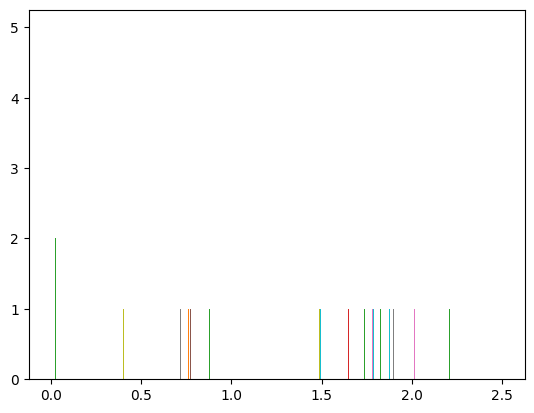

In [ ]:
#@markdown ## Plot the average firing rates for pre-stimulus, stimulus->reaction, post-reaction times:
def compare_rate(trial):
  data = sessionData
  behavioralData = data['behavioralData']
  spike_times=data['spikeTimes'][trial]

  t_start=0 #start in s
  t_stop=2.5
  t_bin= 0.01 #s, 10ms

  dt=t_start-t_stop
  min_timestep=int(t_start/t_bin)
  max_timestep=int(t_stop/t_bin) 
  d_timestep=max_timestep-min_timestep

  spikes_binned=np.zeros((len(spike_times),d_timestep)) #(neuron,times)

  ### BIN SPIKES with T_BIN
  
  for ii in range(0,len(spike_times)): #loop over neurons
    spikes=spike_times[ii]

    for tt in range(0,d_timestep):
        delta_t = tt*t_bin +t_bin
      
        spike_indices=np.where(((tt*t_bin)<spikes) & (spikes<=delta_t))[0] #spike indices in bin
        counts=len(spike_indices)
        
        spikes_binned[ii,tt]=counts
  
  spikes_binned=np.hist(spike_times)


  rates=np.sum(spikes_binned,axis=0)/(t_bin*len(spikes_binned))

  rate_after_stim=np.mean(rates[50:150])

  return rate_after_stim

def high_rate_index(threshold):
  rightContrastTrials = [index for index, rightContrast in enumerate(behavioralData['contrastRight']) if rightContrast == 1 ]
  leftContrastTrials = [index for index, leftContrast in enumerate(behavioralData['contrastLeft']) if leftContrast > behavioralData['contrastRight'][index]]

  compare=[]
  for i in range(0,np.shape(data['spikeTimes'][0])): #loop over trials
    compare.append(compare_rate(i))
  
  compare=np.array(compare)

  high_rate_indices=np.where(compare>threshold)
  high_rate_indices=np.intersect1d(high_rate_indices,rightContrastTrials)

  return compare,high_rate_indices

spike_times=sessionData['spikeTimes'][0]
bins,_,_=plt.hist(spike_times,bins=250)

(66, 250)


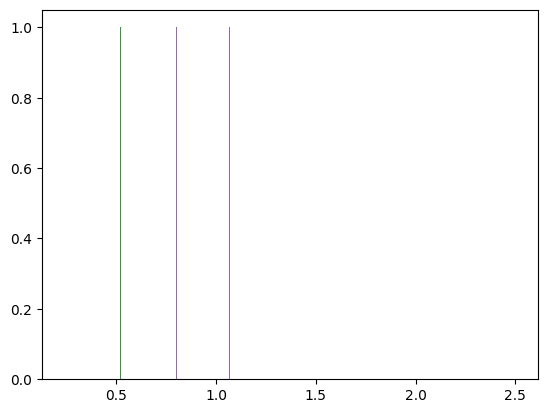

In [ ]:
#@markdown ## Plot the firing rates for the 13th trial:
spike_times=allTrialsSpikeTimes[13]
bins,_,_=plt.hist(spike_times,bins=250)
print(np.shape(bins))

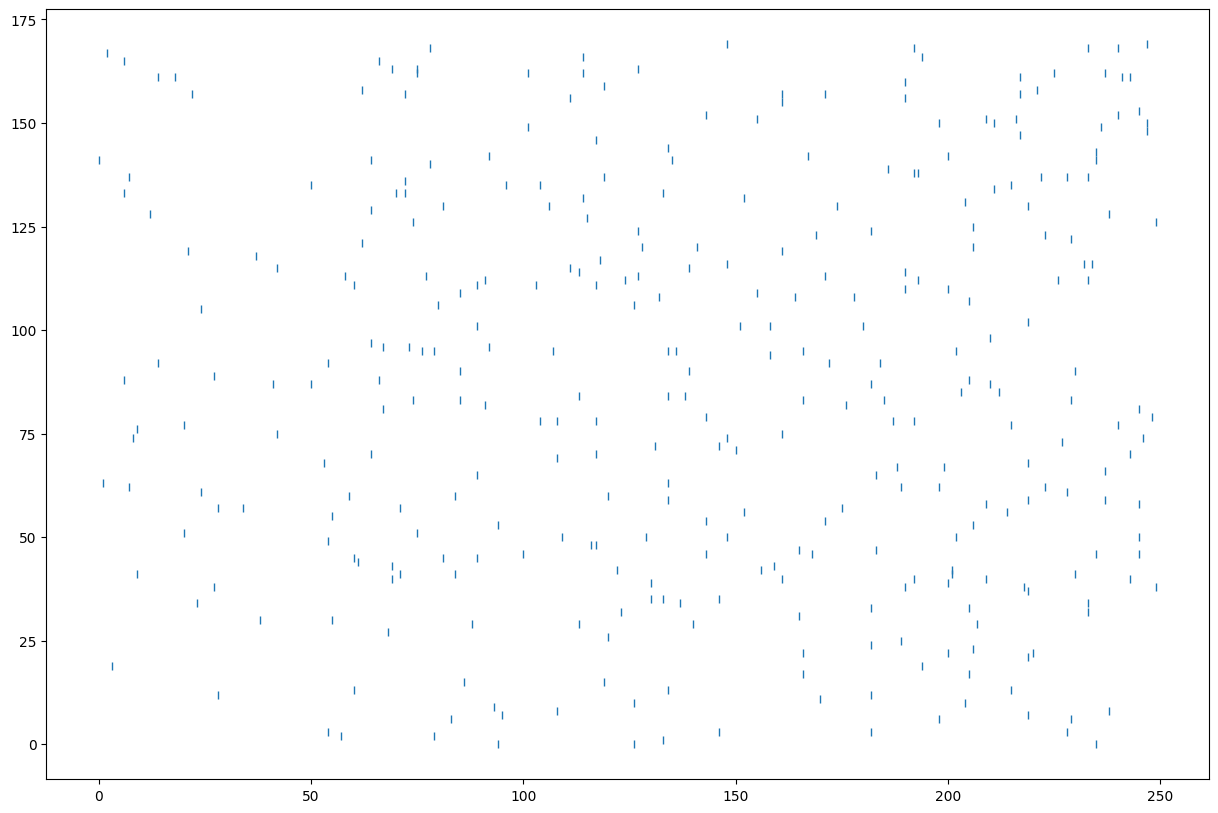

In [ ]:
#@markdown ## Generate simulated Poisson spike trains
#@markdown Using:
#@markdown - r1: 0.55 Hz, rate until stimulus onset
#@markdown - r2: 0.8 Hz, rate after stimulus onset until task end
#@markdown - r3: 1.15 Hz, rate after task end
#@markdown 
#@markdown If we used equal values for all three rates, we would expect to find a single state.
#@markdown 
#@markdown If we used equal values for two rates, and a different third rate, we would expect to find two states.
import random as rd
def generate_spiketrains(r1,r2,r3):

  t=2500 #ms
  t_bin= 10 #s, 10ms

  spikes_binned=np.zeros((170,int(t/t_bin))) #(neuron,times)
  #r1 Hz, rate until stimulus onset
  #r2 Hz, rate after stimulus onset until task end
  #r3 Hz, rate after task end

  for i in range(0,len(spikes_binned)):
    for j in range(0,int(t/t_bin)):
      if j*t_bin < 500:
        if rd.random() < r1*t_bin/1000:
          spikes_binned[i,j]=1
      elif 2000>j*t_bin >= 500:
        if rd.random() < r2*t_bin/1000:
            spikes_binned[i,j]=1
      else:
        if rd.random() < r3*t_bin/1000:
            spikes_binned[i,j]=1

  plotting=np.where(spikes_binned==1)
  plt.figure(figsize=(15,10))
  plt.plot(plotting[1],plotting[0],'|')

generate_spiketrains(0.55,0.8,1.15)

#r1, r2, r3 equal: one state; two rates equal: 2 states expected, three rates equal: 1 state expected

In [ ]:
#@markdown ## Save the data that will be used for the HMM fitting:
#@markdown - 25th session data for VISp 
#@markdown - 30th session data for MOs
import pickle

visualNeurons = extractNeuronsFromSpecificBrainRegion("VISp", alldat)
spikeTimesVisualNeurons = sortSpikeTimesByTrialsWithoutMean(visualSpikeTimes[25])
behavioralDataVisualNeurons = getBehavioralDataForNeurons(visualNeurons, 25)

motorNeurons = extractNeuronsFromSpecificBrainRegion("MOs", alldat)
spikeTimesMotorNeurons = sortSpikeTimesByTrialsWithoutMean(motorSpikeTimes[30])
behavioralDataMotorNeurons = getBehavioralDataForNeurons(motorNeurons, 30)

wheelDataVisual = alldat[25]['wheel']
wheelDataMotor = alldat[30]['wheel']

# Saving the objects:
with open('savedData.pkl', 'wb') as f:
    pickle.dump([visualNeurons, motorNeurons, spikeTimesVisualNeurons, behavioralDataVisualNeurons, spikeTimesMotorNeurons, behavioralDataMotorNeurons, wheelDataVisual, wheelDataMotor], f)

# What we found while examining the data:
## Primary visual cortex
- The neural activity changes during the task
- Only monocular neurons were captured during the experiment (right eye), so we focused only on trials with a high right contrast.
- We found that there are at least two states, visible from the raster plots, which seem to coincide with the behavioral data, for an example:

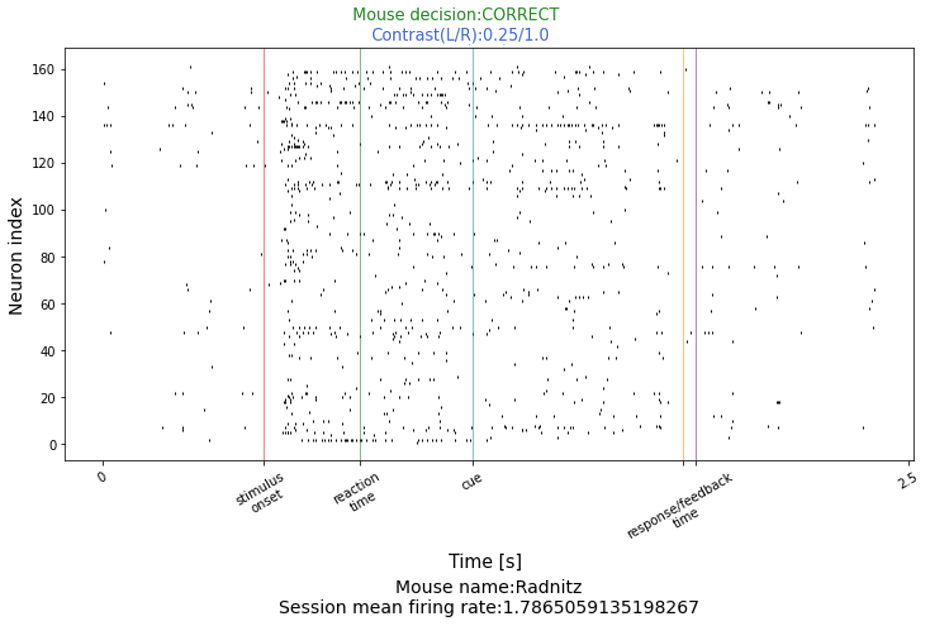

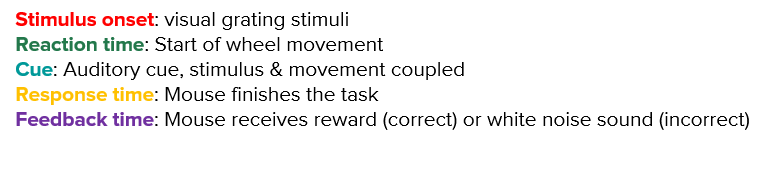


## Secondary motor cortex

- Neural activity changes slightly during the task
- If there are different activity states, they are not easily recognizable from the raster plots
- We decided to use only trials with the wheel movement to the right, since we're focusing on right contrast trials (see above)

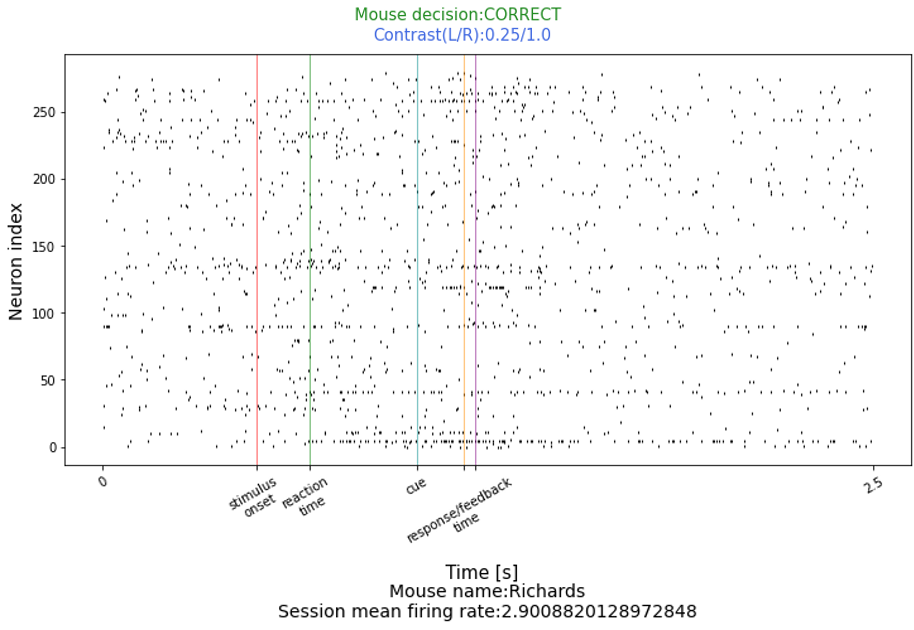

# Implementing the HMM

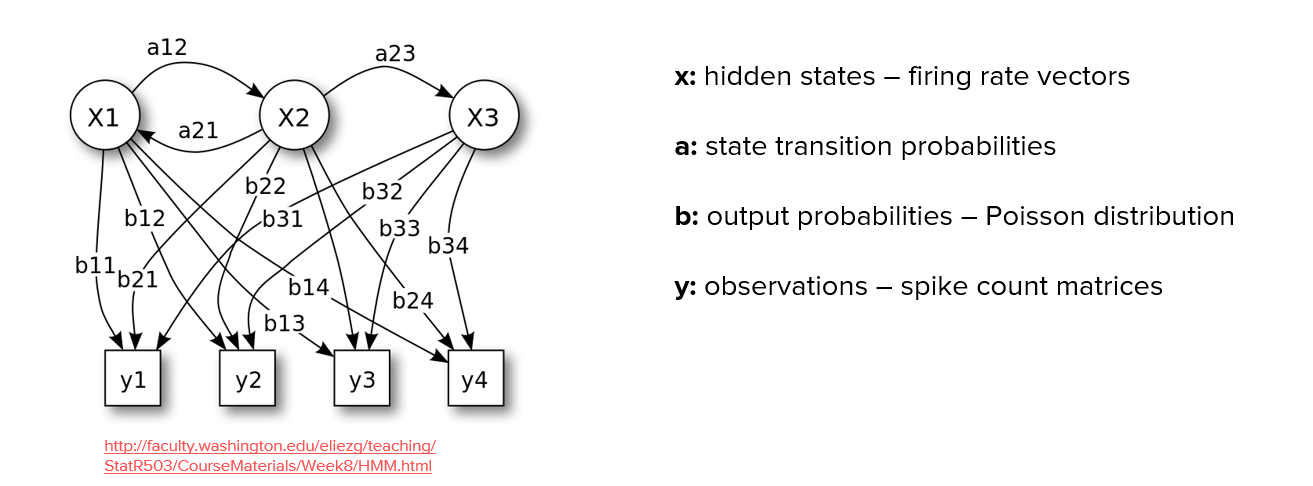



In [ ]:
#@markdown ## Clear Colab RAM and load only the necessary data
%reset -f
import pickle, os
with open('savedData.pkl', 'rb') as f:
  visualNeurons, motorNeurons, spikeTimesVisualNeurons, behavioralDataVisualNeurons, spikeTimesMotorNeurons, behavioralDataMotorNeurons, wheelDataVisual, wheelDataMotor = pickle.load(f)

In [ ]:
#@markdown ## Install dependencies and load libs
!pip install numpy matplotlib scikit-learn autograd cython seaborn statsmodels scipy &> /dev/null
!pip install git+https://github.com/ivanorsolic/ssm &> /dev/null # Change this to ivanorsolic/ssm 
import pickle, os
import numpy as np

In [ ]:
#@title Bin the spike data (binnedSpikesVisualNeurons, binnedSpikesMotorNeurons)
def binTrial(trial, binSize=0.01):
  spike_times = trial
  last_spike=np.zeros(len(spike_times))
  for i in range(0,len(spike_times)):

    spike_count=len(spike_times[i])
    if spike_count > 0:
      last_spike[i]=spike_times[i][-1]
    else:
      last_spike[i]=0


  t_start=0 #start in s
  t_stop=2.5
  t_bin=binSize


  dt=t_start-t_stop
  min_timestep=int(t_start/t_bin)
  max_timestep=int(t_stop/t_bin) 
  d_timestep=max_timestep-min_timestep

  spikes_binned=np.zeros((len(spike_times),d_timestep)) #(neuron,times)

  ### BIN SPIKES with T_BIN
  for ii in range(0,len(spike_times)): #loop over neurons
    spikes=spike_times[ii]

    for tt in range(0,d_timestep):
        delta_t = tt*t_bin +t_bin
      
        spike_indices=np.where(((tt*t_bin)<spikes) & (spikes<=delta_t))[0] #spike indices in bin
        counts=len(spike_indices)
        
        spikes_binned[ii,tt]=counts
  return spikes_binned

def binSpikes():

  binnedSpikesVisualNeurons = []
  binnedSpikesMotorNeurons = []


  for trial in spikeTimesMotorNeurons:
    binnedSpikesMotorNeurons.append(binTrial(trial))
  for trial in spikeTimesVisualNeurons:
    binnedSpikesVisualNeurons.append(binTrial(trial))

  return binnedSpikesVisualNeurons, binnedSpikesMotorNeurons

binnedSpikesVisualNeurons, binnedSpikesMotorNeurons = binSpikes()

## The states we expect to detect
1. Baseline: the period from 0ms to 500ms (stimulus onset)
2. Plan: the period from stimulus onset (500ms) to the cue (variable time)
3. Move: the period from the cue to the response time


In [ ]:
#@markdown ## Set the used data to motor neuron data:

behavioralData = behavioralDataMotorNeurons
wheelData = wheelDataMotor

In [ ]:
#@markdown ## We will unpack our data in the following variables:

#@markdown `binnedSpikesVisualNeurons, binnedSpikesMotorNeurons`: 
#@markdown - A nested array of (trial, neuron, time-bin) with shape (178 trials, 162 neurons, 250 time bins). 
#@markdown - The baseline period always begins at 0ms and ends at 500ms. 
#@markdown - The plan period begins at 500ms and ends whenever the cue is presented (variable).

#@markdown   When calling SSM's fit function, the data is expected to be formatted as a list `datas` where `datas[i]` is a 2D array of size `time_bins X neurons`. Here, we need to reformat our data to match this. For us, this means that each entry of `datas` should be a `250 X number of neurons` (e.g. 162), because we have 162 visual neurons.
### Changing the orientation of the binnedSpikesVisualNeurons Data
def orderDataForSsmFit(binnedSpikes):
  reorderedSpikes = []
  for trial in binnedSpikes:
    reorderedSpikes.append(np.swapaxes(trial, 0, 1))
  return reorderedSpikes

ssmOrderedVisualBins = orderDataForSsmFit(binnedSpikesVisualNeurons)
ssmOrderedMotorBins = orderDataForSsmFit(binnedSpikesMotorNeurons)

In [ ]:
#@markdown ## We will also implement some helper functions to get the `base_idx, plan_idx, move_idx`:
#@markdown 
#@markdown 1. `base_idx`: Indices of time-bins corresponding to the baseline period: this should be [0, 50] for us (50*10ms bins = 500ms).
#@markdown 2. `plan_idx`: Indices of time-bins corresponding to the plan period: this should be [50, gocue] for us or [50, reaction_time]. Let's use `gocue` for now, so we don't have a time gap.
#@markdown 3. `move_idx`: Indices of time-bins corresponding to the movement period: this should be [gocue/reaction_time, response_time] for us.
indices = {}
stimulusOnsetTime = 50 # 500ms = 50*10ms bins
goCue = behavioralData["gocue"]
reactionTime = behavioralData["reaction_time"]
responseTime = behavioralData["response_time"]
feedbackTime = behavioralData["feedback_time"]

def getBaseIdx():
  return slice(0, stimulusOnsetTime)

def getPlanIdx(trial):
  # Go cue values are in seconds.
  # Multiply by 1000 to get millisecond.
  # Floor divide by 10 to get bin index.
  return slice(stimulusOnsetTime, int(goCue[trial] * 1000 // 10))

def getMoveIdx(trial): # Should we use response time or something else?
  # Both values are in seconds.
  # Multiply by 1000 to get millisecond.
  # Floor divide by 10 to get bin index.
  return slice(int(goCue[trial] * 1000 // 10), int(responseTime[trial] * 1000 // 10))

In [ ]:
#@markdown ## Next, we'll split the trials into:
#@markdown - `rightContrastTrials`: trials where the right contrast is larger than the left one
#@markdown - `rightCorrectContrastTrials`: `rightContrastTrials` where the mouse made the correct choice
#@markdown - `leftContrastTrials`: trials where the left contrast is larger than the right one
#@markdown - `leftCorrectContrastTrials`: `leftContrastTrials` where the mouse made the correct choice
#@markdown - `noGoTrials`: trials where the contrasts were the same
#@markdown 
#@markdown We'll also verify that there are no duplicate trials between the three types defined above (left, right, no go).

rightContrastTrials = [index for index, rightContrast in enumerate(behavioralData['contrastRight']) if rightContrast > behavioralData['contrastLeft'][index]]
rightCorrectContrastTrials = [index for index, rightContrast in enumerate(behavioralData['contrastRight']) if rightContrast > behavioralData['contrastLeft'][index] and behavioralData['response'][index] == -1]

leftContrastTrials = [index for index, leftContrast in enumerate(behavioralData['contrastLeft']) if leftContrast > behavioralData['contrastRight'][index]]
leftCorrectContrastTrials = [index for index, leftContrast in enumerate(behavioralData['contrastLeft']) if leftContrast > behavioralData['contrastRight'][index] and behavioralData['response'][index] == 1]

noGoTrials = [x for x in range(250) if x not in rightContrastTrials+leftContrastTrials]

def areThereDuplicateTrials(nogo, left, right):
  return "There are." if len(noGoTrials) == len(set(rightContrastTrials+leftContrastTrials)) else "There aren't."

if "There are." == areThereDuplicateTrials(noGoTrials, leftContrastTrials, rightContrastTrials):
  print("Yikes, something is wrong!")

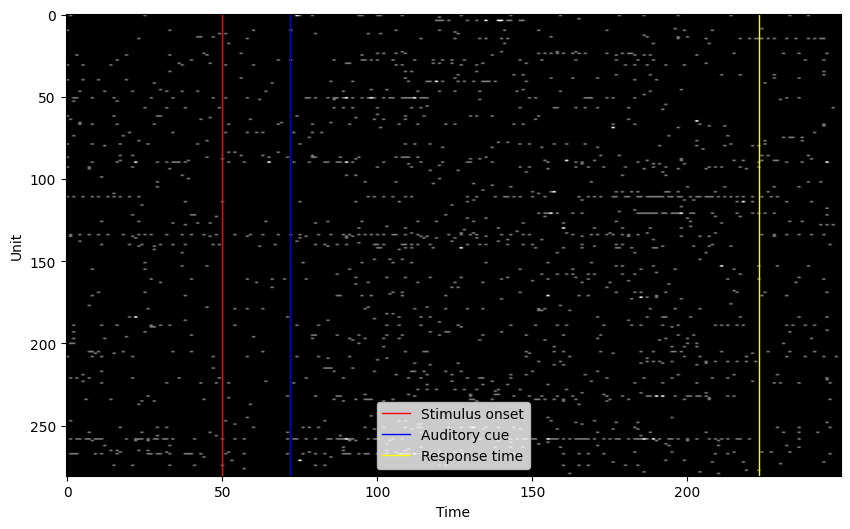

In [ ]:
#@markdown ## Let's plot a spike raster of a single trial, as a sanity check.
import matplotlib.pyplot as plt

# Display a spike raster of the image
plt.figure(figsize=(10,6))
plt.imshow(binnedSpikesMotorNeurons[5], aspect='auto', cmap='gray')
#plt.axis('off')

# Label the different phases of the trial movement activity
time_bins = 250

plan_start = getPlanIdx(5)
move_start = getMoveIdx(5)
plt.axvline(x=plan_start.start, color='red', linewidth=1, label='Stimulus onset')
plt.axvline(x=move_start.start, color='blue', linewidth=1, label='Auditory cue')
plt.axvline(x=move_start.stop, color='yellow', linewidth=1, label='Response time')
plt.ylabel("Unit")
plt.xlabel("Time")
plt.legend()
plt.tight_layout
plt.show()

In [ ]:
#@markdown ## We'll split the data into train and test sets (80:20)
from sklearn.model_selection import train_test_split

def getTrainingTestSets(data):
  indices = [x for x in range(0, len(data))]
  np.random.shuffle(indices)
  split = int(len(indices)*0.8)
  return indices[:split], indices[split:]

trainSetVisual, testSetVisual = getTrainingTestSets(ssmOrderedVisualBins)
trainSetMotor, testSetMotor = getTrainingTestSets(ssmOrderedVisualBins)

In [ ]:
#@markdown ## Code for the HMM
#@markdown The observations follow a poisson distribution, which was determined by data examination and simulation.
#@markdown The Expectation-maximization algorithm is used for optimisation.
#@markdown - We manually set the number of states we're trying to fit:
#@markdown   -  This is a hyperparameter that is best fit using methods like cross-validation.
#@markdown   -  You basically try to figure out which number of states works best by trial and error.
#@markdown - We manually initialise the initial state distribution by:
#@markdown   -  Setting the probability of the first state to 100% and the rest to 0%.
#@markdown - We also manually initialise the transition probabilities:
#@markdown   -  We set the probabilities of switching between states to 10%. 
#@markdown   -  We set the diagonal probabilities to 100 - ((n-1)*10)%, which denote the probability of staying in the same state.
#@markdown   -  If we had only two states, then the probability of staying in the same state would be 90%.
#@markdown   -  If we had three states, then the probability of staying in the same state would be 80%.




import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap
def initializeAndFitHMM(train_datas, numIters=100):
  num_states = 3
  try:
    num_neurons = train_datas[0].shape[1]
  except Exception as e:
    num_neurons = train_datas.shape[1]

  # Manually set the initial state distribution
  init_dist = ssm.init_state_distns.FixedInitialStateDistribution(num_states,
                                                                  num_neurons,
                                                                  pi0 = np.array([1.0, 0.0, 0.0]))
  # Create our HMM
  simple_hmm = ssm.HMM(num_states,
                      num_neurons,
                      observations="poisson",
                      transitions="standard",
                      init_state_distn=init_dist)
  
  # Manually initialize the transition probabilities
  
  A=np.array([[0.9, 0.1, 0.1],
              [0.1, 0.9, 0.1],
              [0.1, 0.1, 0.9]])

  #simple_hmm.log_lambdas = np.log(lambdas + 1e-16)
  simple_hmm.transitions.log_Ps = np.log(A + 1e-16)

  lls = simple_hmm.fit(train_datas, method='em', num_iters=numIters)

  return simple_hmm

In [ ]:
#@markdown ## Plotting code initialization.
#@markdown Note: very messy.
def plotPosteriorOverRaster(trialNumber, neuronType):
  if neuronType == "visual":
    train_datas, simple_hmm = trainDatasVisual, hmmVisual
  elif neuronType == "single":
    train_datas, simple_hmm = trainDatasVisual, hmmVisualSingle
  else:
    train_datas, simple_hmm = trainDatasMotor, hmmMotor
  # Plot posterior over raster plot
  # Display a spike raster of the image
  fig = plt.figure(figsize=(20, 8))
  spikes = train_datas[trialNumber]
  plt.imshow(np.array(np.swapaxes(spikes, 0, 1), dtype=float), aspect='auto', cmap='gray')
  
  # Label the different phases of the trial movement activity
  time_bins = 250

  plan_start = getPlanIdx(trialNumber)
  move_start = getMoveIdx(trialNumber)
  plt.axvline(x=plan_start.start, color='red', linewidth=3, label='Stimulus onset')
  plt.axvline(x=move_start.start+50, color='blue', linewidth=3, label='Auditory cue')
  plt.axvline(x=move_start.stop+50, color='yellow', linewidth=3, label='Response time')
  plt.axvline(x=int(behavioralData['reaction_time'][trialNumber][0]  // 10)+50, color='orange', linewidth=3, label='Reaction time')
  plt.ylabel("Unit")
  plt.xlabel("Time")

  posterior = simple_hmm.filter(train_datas[trialNumber])
  # plot posterior of states for a single test trial
  for i in range(0, 5):
    plt.plot(posterior[:,i]*(train_datas[trialNumber].shape[1]-1), label="State %d" % i, linewidth=1)
      
  # # plt.tight_layout
  plt.legend()
  plt.figure(figsize=(20, 8))
  posterior = simple_hmm.filter(train_datas[trialNumber])
  # plot posterior of states for a single test trial
  for i in range(0, 5):
    plt.plot(posterior[:,i]*(train_datas[trialNumber].shape[1]-1), label="State %d" % i, linewidth=1)
  plt.axvline(x=plan_start.start, color='red', linewidth=1, label='Stimulus onset')
  plt.axvline(x=move_start.start+50, color='blue', linewidth=1, label='Auditory cue')
  plt.axvline(x=move_start.stop+50, color='yellow', linewidth=1, label='Response time')
  plt.axvline(x=int(behavioralData['reaction_time'][trialNumber][0]  // 10)+50, color='orange', linewidth=3, label='Reaction time')
      
  # # plt.tight_layout
  plt.legend()
  plt.show()

def plotWheelSpeed(trialID, window):
  wheelPositionSingleTrial = wheelData[0]
  wheelPosition = wheelPositionSingleTrial[trialID]
  # wheelSpeed = np.diff(wheelPosition)/10
  # wheelSpeed = my_moving_window(wheelSpeed, window = window, FUN=np.mean)
  wheelPosition = np.cumsum(wheelPosition)


  plt.figure(figsize=(12, 4))
  plt.plot(wheelPosition, color='green')
  # plt.ylabel('Wheel Speed [Position/Time Bins]',fontsize=14)
  plt.xlabel('Time Bins [10 ms]',fontsize=14)
  
  move_start = getMoveIdx(trialID)
  plt.axvline(x=move_start.stop+50, color='black', linewidth=1, label='Response time')

In [ ]:
#@markdown ## Train a three-state model on right contrast trials over 100 iterations.
rightTrials = [ssmOrderedMotorBins[x] for x in rightCorrectContrastTrials]
hmmSimulated = initializeAndFitHMM([spikes.astype(int) for spikes in rightTrials], numIters=100)

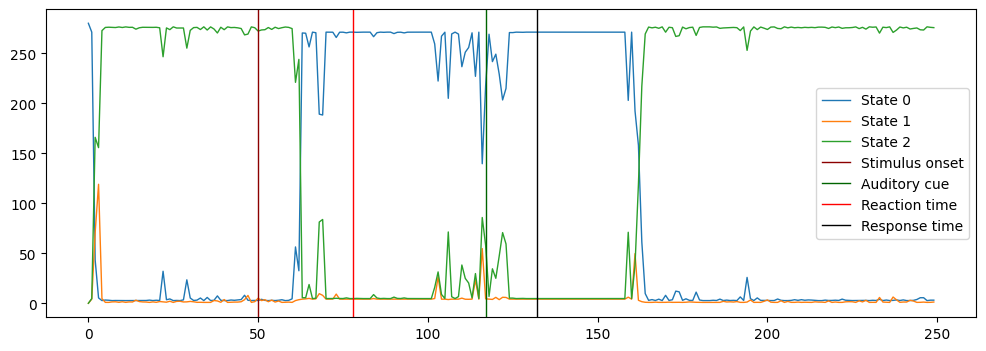

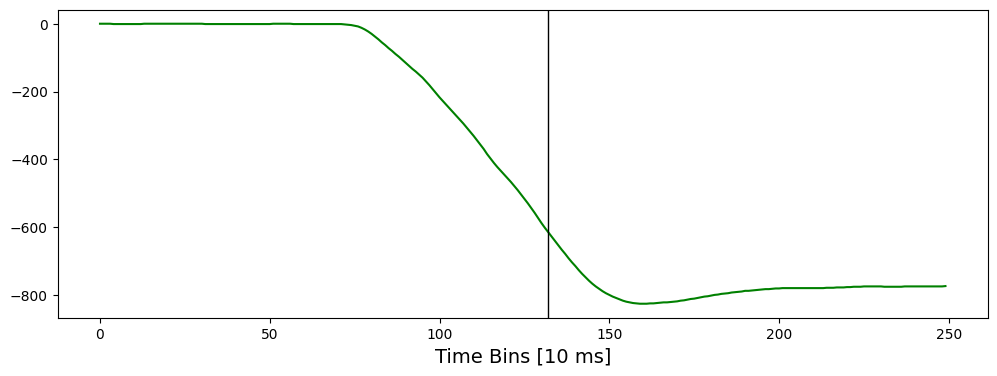

In [ ]:
#@markdown ## Plot the posterior of states for a single test trial (13th trial):
plt.figure(figsize=(12, 4))
# 13th trial
selectedTrial = 7
posterior = hmmSimulated.filter(ssmOrderedMotorBins[selectedTrial].astype(int))
# plot posterior of states for a single test trial
for i in range(0, 3):
  plt.plot(posterior[:,i]*(ssmOrderedMotorBins[selectedTrial].shape[1]-1), label="State %d" % i, linewidth=1)
plan_start = getPlanIdx(selectedTrial)
move_start = getMoveIdx(selectedTrial)
plt.axvline(x=plan_start.start, color='darkred', linewidth=1, label='Stimulus onset')
plt.axvline(x=move_start.start+50, color='darkgreen', linewidth=1, label='Auditory cue')
plt.axvline(x=int(behavioralData['reaction_time'][selectedTrial][0]  // 10)+50, color='red', linewidth=1, label='Reaction time')
plt.axvline(x=move_start.stop+50, color='black', linewidth=1, label='Response time')
plt.legend()
plotWheelSpeed(selectedTrial, 250)
# plt.tight_layout
plt.show()

# The results
## Primary visual cortex
Keeping in mind we only used correct right contrast trials (29 in total), since the recorded visual neurons only included neurons from a monocular region (the right eye):
- Fitting 3 or more states to 29 trials seems to capture a lot of noise
- There is no strong correlation between behaviour and states
- We believe that these results stems from the lack of data, since we're only using 29 trials
- We decided to fit simulated data, using the firing rates found in the 29 trials of actual data

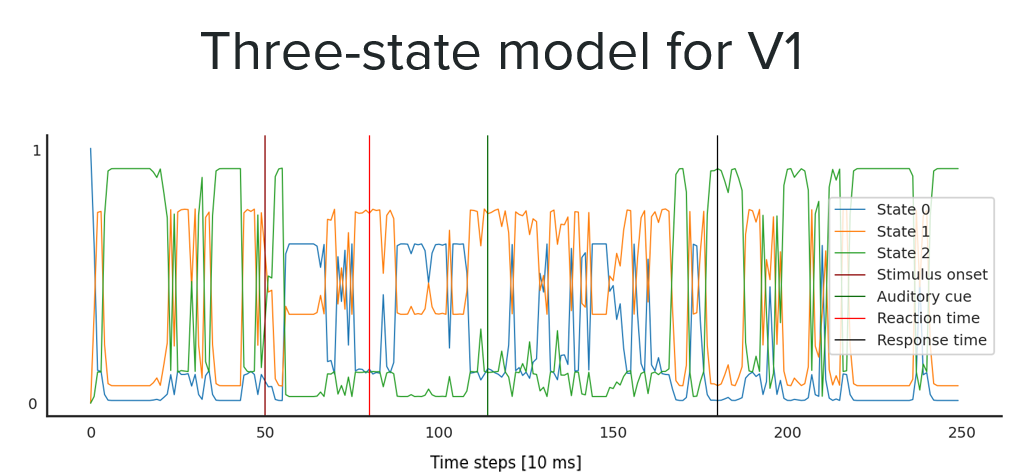

## Simulated data

After fitting a three-state model to simulated data (as described above), we found that:

- Fitting 3 state to even only 29 trials of simulated data works quite well.
- Either more experimental data is needed or;
- Discrete state sequences are not a good description of activity in V1 or;
- State sequences in V1 represent more complex features.

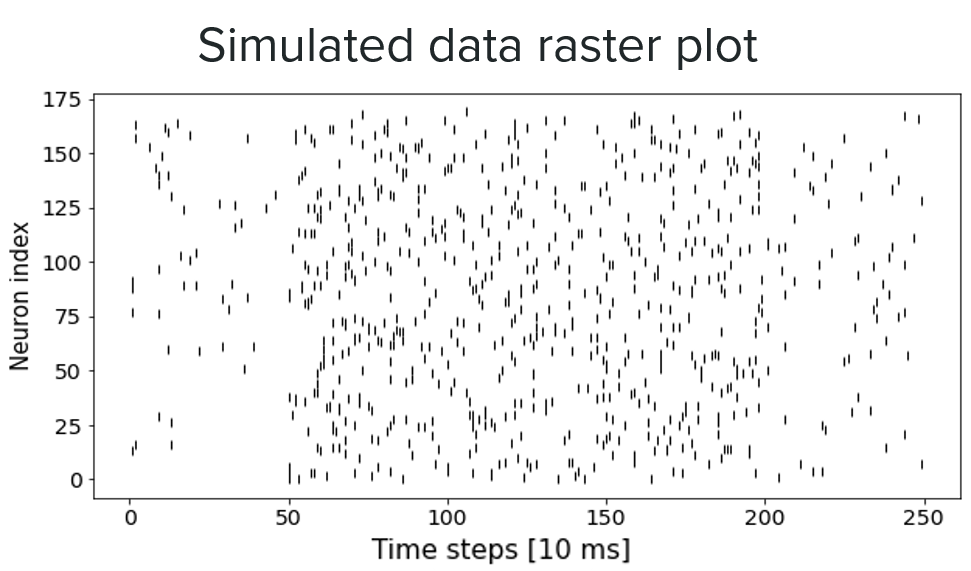

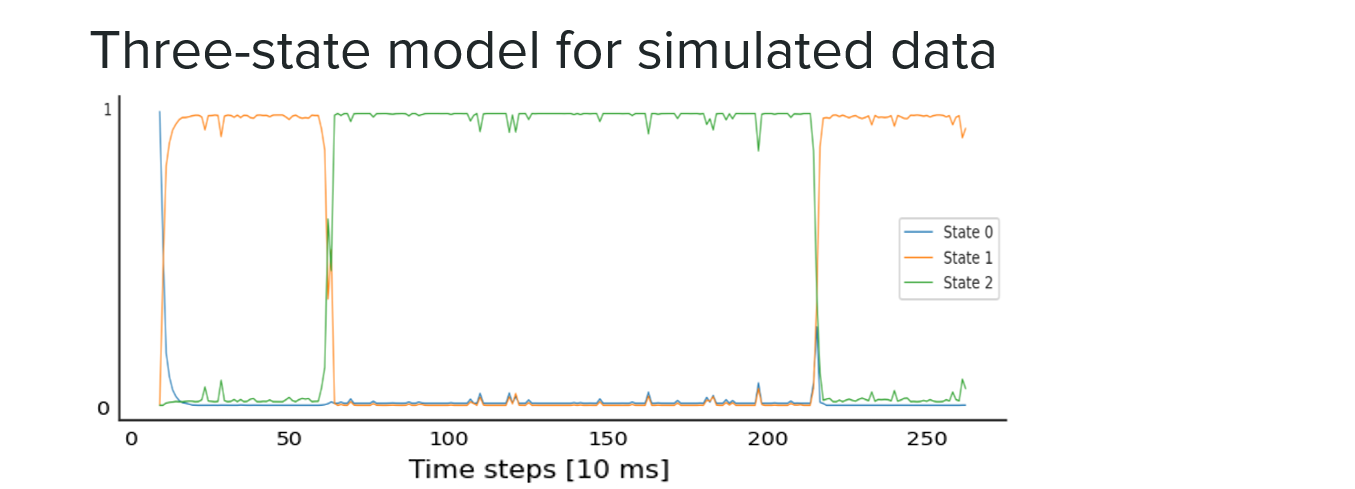


## Primary visual cortex (two-state model)

After simulating data and fitting a three-state HMM to it, we went back to the primary visual cortex data and tried to fit a two-state model to it, where we found that:

- Even if quite noisy – the two-state model seems to capture the onset of the visual stimulus as well as the task end.

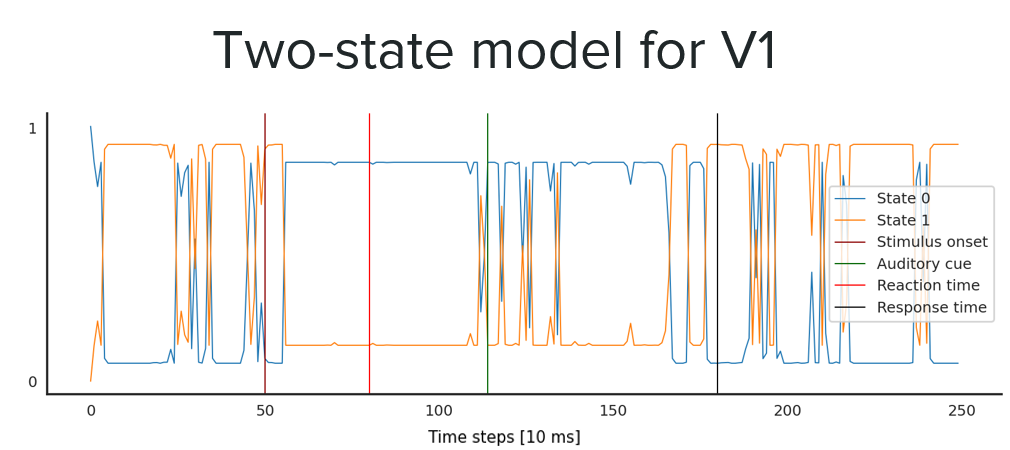


## Secondary motor cortex 

Suprisingly enough, we were able to fit a three-state model to the secondary motor cortex data nicely, even though the raster plots wouldn't seem to directly imply the existence of those states. We found that: 

- For the M2 data the HMM states correlate with the following behaviour:
 0. No locomotion
 1. Movement
 2. Movement initiation
 
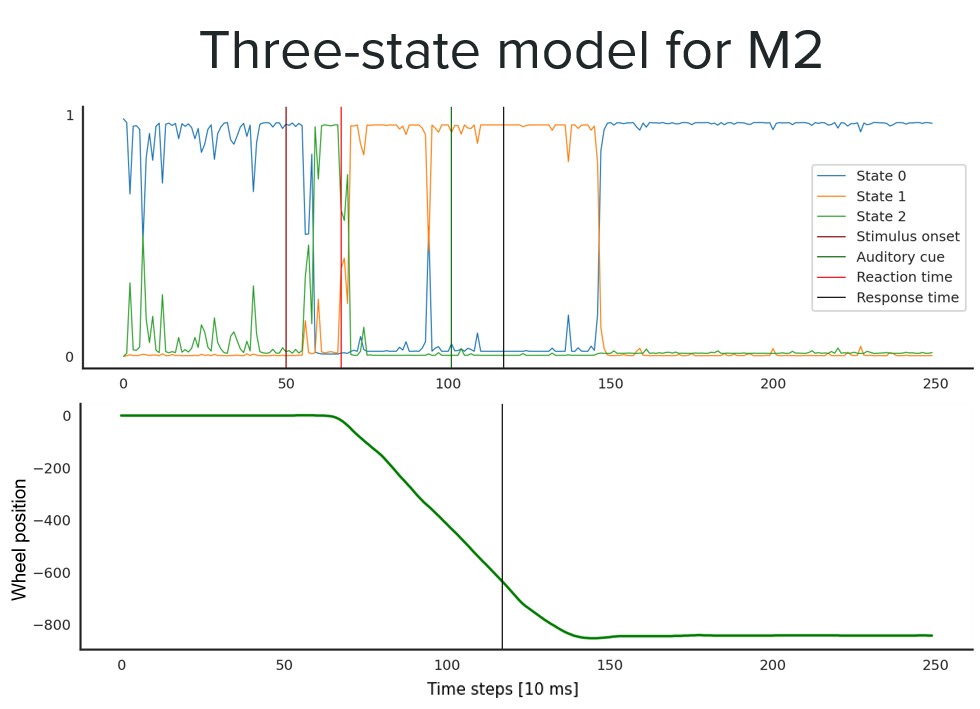